<a href="https://colab.research.google.com/github/Lamiae7/Applied-data-science-capstone_coursera/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Libreries

In [19]:

## for data
import pandas as pd
import numpy as np
import sklearn
from datetime import datetime
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for machine learning
from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split
# Deep Learning Libraries
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.layers import Embedding, Input, dot, concatenate
from keras.models import Model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import to_categorical
import pydot

### Data wrangling

In [20]:
df_movies = pd.read_table('movies.dat',sep="::",encoding='ISO-8859-1',engine='python')
df_movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


Let's have a combined view on both the ratings and movies dataframe.

And for that we need to merge on "MovieID" attribute since it is common between both the dataframes.

In [21]:
df_ratings= pd.read_table('ratings.dat',sep="::",encoding='ISO-8859-1',engine='python')
df_ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760.0
1,1,661,3,978302109.0
2,1,914,3,978301968.0
3,1,3408,4,978300275.0
4,1,2355,5,978824291.0


In [22]:
df_ratings.drop(['Timestamp'], axis=1, inplace=True)
df_ratings.head()

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [23]:
df_combined = pd.merge(df_ratings,df_movies, on = 'MovieID')
df_combined.head()

,UserID,MovieID,Rating,Title,Genres
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama


### Splitting Data into Train and Validation Set

In [24]:
users = df_combined['UserID'].unique()
movies = df_combined['MovieID'].unique()

userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

df_combined['UserID'] = df_combined['UserID'].apply(lambda x: userid2idx[x])
df_combined['MovieID'] = df_combined['MovieID'].apply(lambda x: movieid2idx[x])
split = np.random.rand(len(df_combined)) < 0.8
train = df_combined[split]
valid = df_combined[~split]
print(train.shape , valid.shape)
train

(106319, 5) (26649, 5)


,UserID,MovieID,Rating,Title,Genres
0,0,0,5,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,0,5,One Flew Over the Cuckoo's Nest (1975),Drama
2,2,0,4,One Flew Over the Cuckoo's Nest (1975),Drama
3,3,0,4,One Flew Over the Cuckoo's Nest (1975),Drama
4,4,0,5,One Flew Over the Cuckoo's Nest (1975),Drama
...,...,...,...,...,...
132963,242,3339,5,Criminal Lovers (Les Amants Criminels) (1999),Drama|Romance
132964,242,3340,5,Whatever Happened to Aunt Alice? (1969),Crime|Thriller
132965,242,3341,4,"Killing of Sister George, The (1968)",Drama
132966,242,3342,4,"Brother, Can You Spare a Dime? (1975)",Documentary


In [25]:
X = df_ratings.iloc[:,:2]
Y = df_ratings.iloc[:,2]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 66)


### Building the Model using Embedding Layers

In [27]:
# The number of latent factors for the embedding
n_latent_factors = 50

# no of users and movies
#n_users, n_movies = len(df_ratings['UserID'].unique()), len(df_ratings['MovieID'].unique()) 

n_users, n_movies = len(df_combined['UserID'].unique()), len(df_combined['MovieID'].unique()) 

### Deep learning model

In [28]:

# User Embeddings
user_input = Input(shape=(1,), name='User_Input')
user_embeddings = Embedding(input_dim = n_users, output_dim=n_latent_factors, input_length=1, 
                              name='User_Embedding') (user_input)
user_vector = Flatten(name='User_Vector') (user_embeddings)



# Movie Embeddings
movie_input = Input(shape=(1,), name='Movie_Input')
movie_embeddings = Embedding(input_dim = n_movies, output_dim=n_latent_factors, input_length=1, 
                               name='Movie_Embedding') (movie_input)
movie_vector = Flatten(name='Movie_Vector') (movie_embeddings)


# Concatenate Product
merged_vectors = concatenate([user_vector, movie_vector], name='Concantenate')
dense_layer_1 = Dense(150, activation='relu')(merged_vectors) 
# dense_layer_1 = Dropout(0.25) (dense_layer_1)
# batchnorm_layer_1 = BatchNormalization()(dense_layer_1)
dense_layer_2 = Dense(100, activation='relu')(merged_vectors)
dense_layer_3 = Dense(50, activation='relu')(merged_vectors)

result = Dense(1)(dense_layer_1)
model = Model([user_input, movie_input], result)

sim=dot([user_vector,movie_vector],name='Simalarity-Dot-Product',axes=1)
model1 = Model([user_input, movie_input],sim)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 User_Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Movie_Input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 User_Embedding (Embedding)     (None, 1, 50)        42900       ['User_Input[0][0]']             
                                                                                                  
 Movie_Embedding (Embedding)    (None, 1, 50)        167200      ['Movie_Input[0][0]']            
                                                                                              

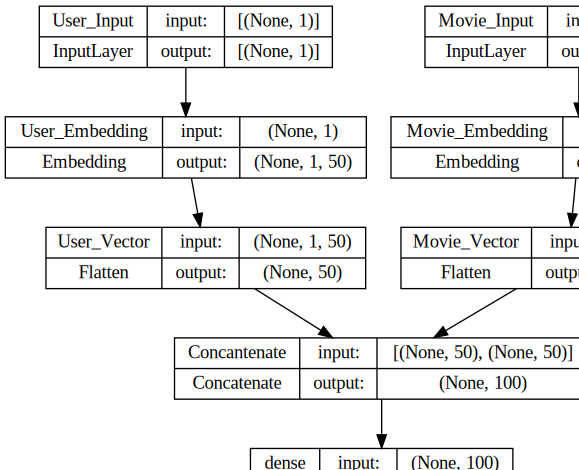

In [29]:
SVG(model_to_dot( model,  show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

### Compiling the Model

In [30]:
optimizer = Adam(lr=0.0002)
model.compile(loss='mean_squared_error', optimizer=optimizer)

#model1.compile(loss='mean_squared_error', optimizer=optimizer)

### Fitting the Model

In [45]:
batch_size = 6
epochs = 1

In [42]:
history = model.fit(x=[x_train['UserID'], x_train['MovieID']], y=y_train['Rating'], batch_size= batch_size, epochs=epochs,verbose= 2, validation_data=([x_test['UserID'], x_test['MovieID']], y_test['Rating']))

KeyError: ignored

In [50]:
history = model.fit([train.UserID,train.MovieID],train.Rating, batch_size=batch_size,
                              epochs =epochs, validation_data = ([valid.UserID,valid.MovieID],valid.Rating))

UnimplementedError: ignored

history = model.fit(x=[x_train['UserID'], x_train['MovieID']], y=y_train['Rating'], batch_size= batch_size, epochs=epochs,verbose= 2, validation_data=([x_test['UserID'], x_test['MovieID']], y_test['Rating']))

#history = model.fit([train.UserID,train.MovieID],train.Rating, batch_size=batch_size,
                              epochs =epochs, validation_data = (valid.UserID,valid.MovieID,valid.Rating),
                              verbose = 2)

### Plotting Validation Curves

In [49]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

NameError: ignored

### Evaluating RMSE

In [ ]:
score = model.evaluate([valid.UserID,valid.MovieID],valid.Rating)

#score = model1.evaluate([valid.UserID,valid.MovieID],valid.Rating)

print()
print('\n','RMSE: {:.4f}'.format(np.sqrt(score)))

6247/6247 [==============================] - 12s 2ms/step - loss: 1.1026


 RMSE: 1.0501
